## Importing the necessary modules


In [1]:
from json import loads
from random import shuffle
from string import punctuation

import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import CSVLogger, ModelCheckpoint, TensorBoard
from keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU, Softmax
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import plot_model
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from numpy import array

"""
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('omw-1.4')
nltk.download("punkt_tab")
"""

'\nnltk.download("punkt")\nnltk.download("wordnet")\nnltk.download(\'omw-1.4\')\nnltk.download("punkt_tab")\n'

## Loading the dataset


In [2]:
data = loads(open("../dataset/intents.json", encoding="utf-8").read())

## Using NLP to clean the data


In [3]:
lemmatizer = WordNetLemmatizer()

# Each list to create
words = []  # tokenized words of sentences in patterns
classes = []  # tags
doc_X = []  # patterns
doc_y = []  # tags ocurring number of times wrt patterns

"""Looping through all the intents and tokenizing each patterns and
appending tokens to words, patterns and associated tag to
their associated list"""
for intent in data["intents"]:
    for pattern in intent["patterns"]:
        tokens = word_tokenize(pattern)
        words.extend(tokens)
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    # add the tag to the classes if it's not there already
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

In [4]:
# lemmatizing all the words in the vocab and
# converting them to lowercase if the words
# don't appear in punctuation
words = [
    lemmatizer.lemmatize(word.lower()) for word in words if word not in punctuation
]

In [5]:
"""sorting the vocab and classes in alphabetical order
and taking the set to ensure no duplicates occur"""

words = sorted(set(words))
classes = sorted(set(classes))

In [6]:
print("lenght of words: ", len(words))
print("length of doc_X", len(doc_X))
print("length of doc_y", len(doc_y))
print("length of classes", len(classes))

lenght of words:  173
length of doc_X 231
length of doc_y 231
length of classes 61


## Creating training and test sets


In [7]:
# list for training data
training = []

# creating the bag of words model
for idx, doc in enumerate(doc_X):
    bow = []
    # lemmatizing the sentence and converting to lowercase
    text = lemmatizer.lemmatize(doc.lower())
    for word in words:
        # one hot encoding the words if they appear in the text
        if word in text:
            bow.append(1)
        else:
            bow.append(0)
    output_row = [0] * len(classes)
    # marking the index of class that the current pattern is associated to as 1
    output_row[classes.index(doc_y[idx])] = 1
    # adding the one hot encoded BoW and associated classes to training
    training.append([bow, output_row])

In [8]:
# shuffling the data and convert it to a numpy array
shuffle(training)
training = array(training, dtype=object)

In [9]:
# splitting the features and target labels
train_X = array(list(training[:, 0]))  # features
train_y = array(list(training[:, 1]))  # target labels

In [10]:
print(train_X)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [11]:
print(train_y)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [12]:
print(f"Shape of train_X: {train_X.shape}")
print(f"Shape of train_y: {train_y.shape}")

Shape of train_X: (231, 173)
Shape of train_y: (231, 61)


# Building deep learning model


In [13]:
# defining some parameters
input_shape = (len(train_X[0]),)
output_shape = len(train_y[0])
print("input_shape: ", input_shape)
print("output_shape: ", output_shape)

input_shape:  (173,)
output_shape:  61


In [14]:
model = Sequential(
    layers=[
        Input(shape=input_shape),
        Flatten(),
        Dense(256),
        LeakyReLU(negative_slope=0.2),
        Dropout(0.25),
        Dense(128),
        LeakyReLU(negative_slope=0.2),
        Dropout(0.25),
        Dense(64),
        LeakyReLU(negative_slope=0.2),
        Dropout(0.25),
        Dense(output_shape),
        Softmax(),
    ],
    name="chatKGEC",
)

In [15]:
model.layers

[<Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <LeakyReLU name=leaky_re_lu, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense_1, built=True>,
 <LeakyReLU name=leaky_re_lu_1, built=True>,
 <Dropout name=dropout_1, built=True>,
 <Dense name=dense_2, built=True>,
 <LeakyReLU name=leaky_re_lu_2, built=True>,
 <Dropout name=dropout_2, built=True>,
 <Dense name=dense_3, built=True>,
 <Softmax name=softmax, built=True>]

In [16]:
model.summary()

Model: "chatKGEC"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 173)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        44,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 61)             │         3,965 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 61)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,661 (350.24 KB)

 Trainable params: 89,661 (350.24 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# compiling the model
adam = Adam(learning_rate=0.01)
model.compile(
    optimizer=adam, loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()]
)

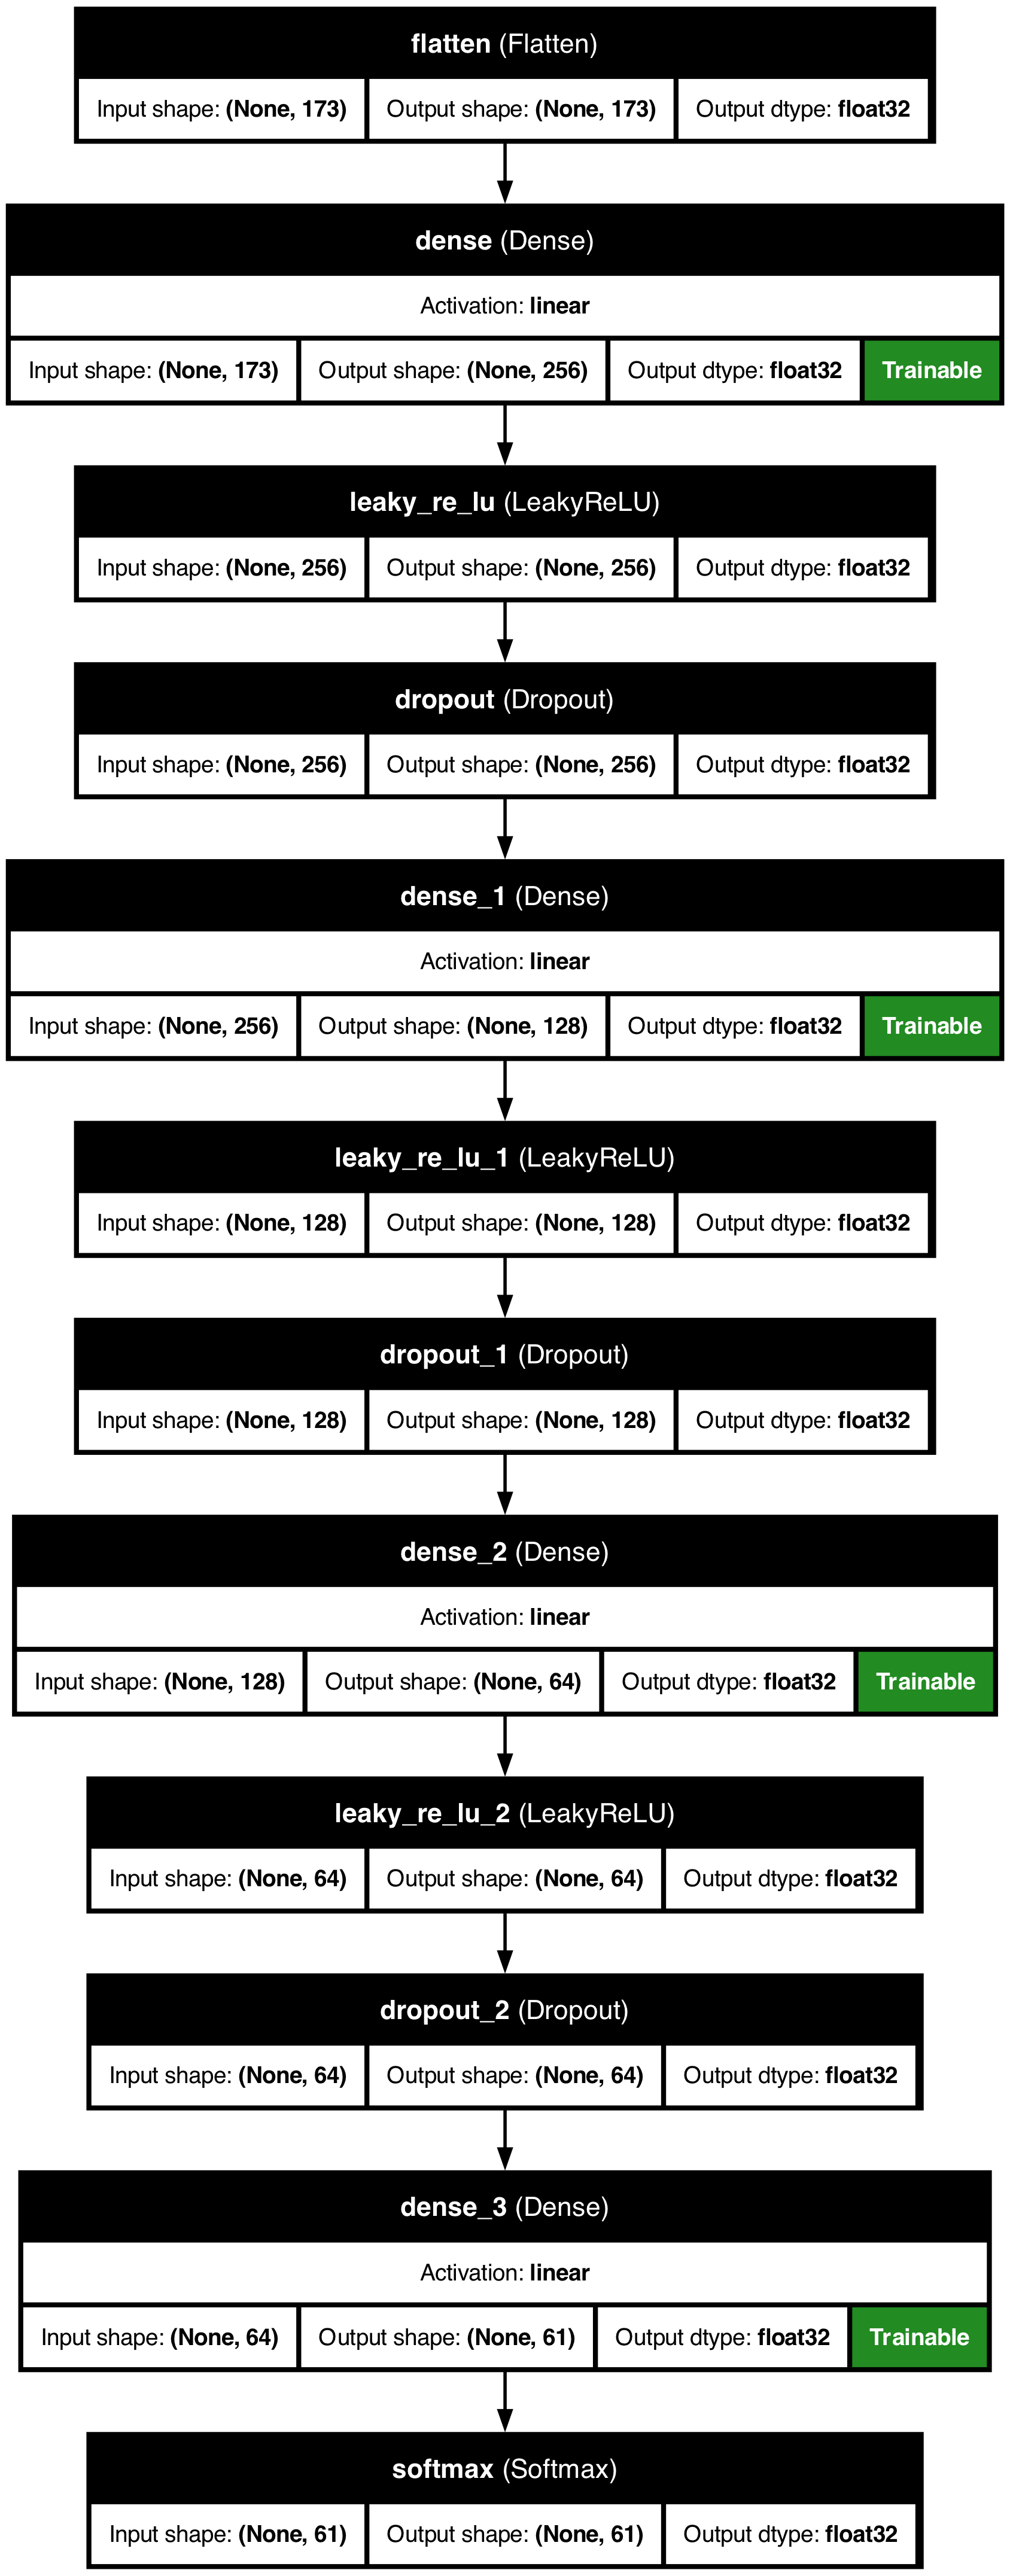

In [18]:
plot_model(
    model,
    to_file="../Images/chatKGEC.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    show_layer_activations=True,
    show_trainable=True,
)

## Training the model


In [19]:
model_checkpoint_callback = ModelCheckpoint(
    filepath="../Model/chatKGEC.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
)
model_tensorboard_callback = TensorBoard(
    log_dir="../Logs/chatKGEC_logs",
    histogram_freq=1,
    write_images=True,
    write_steps_per_second=True,
)
# tensorboard --logdir="Logs/chatKGEC_logs"

model_csvlogger_callback = CSVLogger("../Logs/chatKGEC_logs.csv")

model_history = model.fit(
    train_X,
    train_y,
    batch_size=64,
    epochs=100,
    validation_split=0.1,
    callbacks=[
        model_checkpoint_callback,
        model_tensorboard_callback,
        model_csvlogger_callback,
    ],
)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - categorical_accuracy: 0.0396 - loss: 4.0735 - val_categorical_accuracy: 0.0833 - val_loss: 3.9345
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_accuracy: 0.1133 - loss: 3.4739 - val_categorical_accuracy: 0.0833 - val_loss: 3.6056
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_accuracy: 0.2590 - loss: 2.7967 - val_categorical_accuracy: 0.0833 - val_loss: 3.1903
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.4363 - loss: 2.0958 - val_categorical_accuracy: 0.3750 - val_loss: 2.3870
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_accuracy: 0.4851 - loss: 1.7611 - val_categorical_accuracy: 0.3750 - val_loss: 2.2812
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_accuracy: 0.5887 - loss: 1.2547 - val_categorical_accuracy: 0.2917 - val_loss: 2.6033
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.7085 - loss: 0.8927 - v

In [20]:
model_train_loss = model_history.history["loss"]
model_train_acc = model_history.history["categorical_accuracy"]
model_val_loss = model_history.history["val_loss"]
model_val_acc = model_history.history["val_categorical_accuracy"]

print("Training loss:", np.mean(model_train_loss))
print("Validation loss:", np.mean(model_val_loss))
print(
    "%f Training accuracy with a standard deviation of %f"
    % (np.mean(model_train_acc), np.std(model_train_acc))
)
print(
    "%f Validation accuracy with a standard deviation of %f"
    % (np.mean(model_val_acc), np.std(model_val_acc))
)

Training loss: 0.3803278459608555
Validation loss: 1.3297558799386024
0.892560 Training accuracy with a standard deviation of 0.156016
0.755833 Validation accuracy with a standard deviation of 0.159863


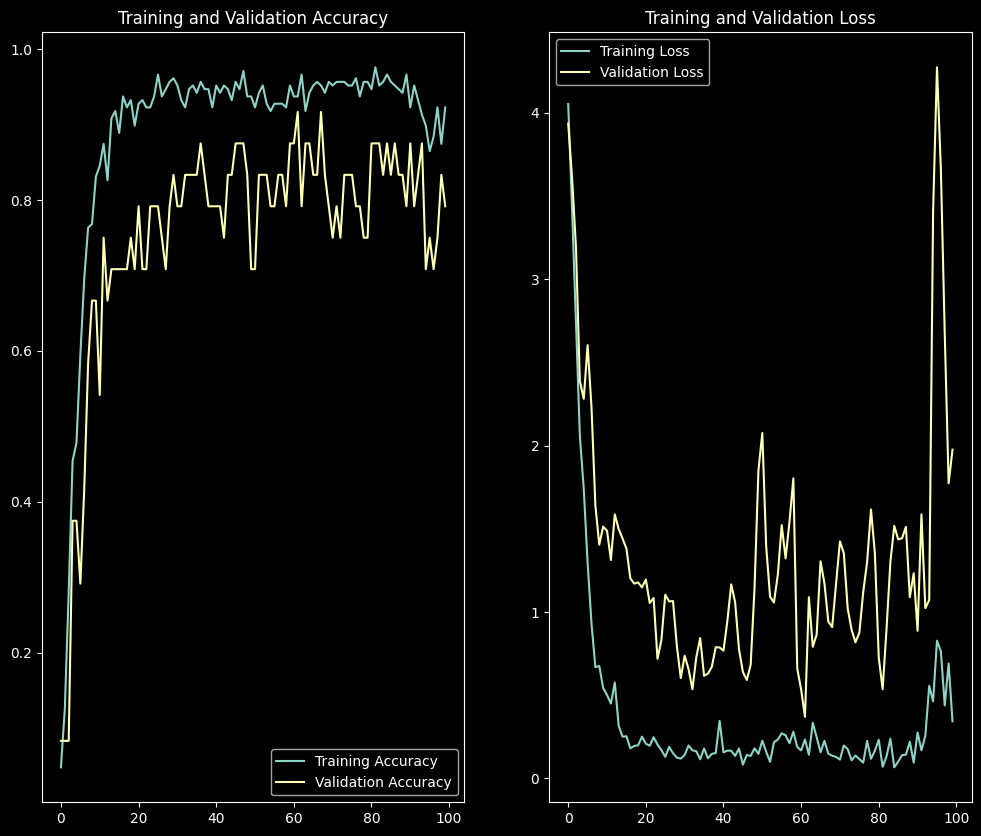

In [21]:
epochs_range = range(100)

# Plot the training and validation accuracy
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, model_train_acc, label="Training Accuracy")
plt.plot(epochs_range, model_val_acc, label="Validation Accuracy")
plt.legend(loc="best")
plt.title("Training and Validation Accuracy")

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, model_train_loss, label="Training Loss")
plt.plot(epochs_range, model_val_loss, label="Validation Loss")
plt.legend(loc="best")
plt.title("Training and Validation Loss")

plt.savefig("../Images/chatKGEC_acc_loss.png", bbox_inches="tight")